# Color Distribution analysis

This notebook measure the distance between color distribution in each channel<br>

Input files: "working/df_colors.csv", "working/df_evaluation_model2.csv"<br>
Output file: "working/df_distance.csv"

In [1]:
import numpy as np
import pandas as pd
import os
import math
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from sklearn.linear_model import Ridge

import PIL
from PIL import Image

import skimage
from skimage.io import imread
from skimage.color import rgb2lab, lab2rgb

import cv2
import pymc as pm

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%run Distance/Distance_metrics.ipynb
%run Performance/Performance_metrics.ipynb
%run Colors/Visualization_functions.ipynb
#%run Colors/Skin_color_functions.ipynb

In [3]:
root = "d:/ham/"
df_path = root + "working/df_colors.csv"
df = pd.read_csv(df_path)

# Read data after the prediction
test_df_path = root + "working/df_evaluation_model2.csv"
test_df = pd.read_csv(test_df_path)

# To add channel information to testdataset
tmp = df[["filepaths", "RGB R", "RGB G", "RGB B", "HSV H", "HSV S", "HSV V", "LAB L", "LAB A", "LAB B"]]
test_df = test_df.merge(tmp, how="left", on="filepaths")
test_df["RGB R"] = round(test_df["RGB R"])
test_df["RGB G"] = round(test_df["RGB G"])
test_df["RGB B"] = round(test_df["RGB B"])
test_df["HSV H"] = round(test_df["HSV H"])
test_df["HSV S"] = round(test_df["HSV S"])
test_df["HSV V"] = round(test_df["HSV V"])
test_df["LAB L"] = round(test_df["LAB L"])
test_df["LAB A"] = round(test_df["LAB A"])
test_df["LAB B"] = round(test_df["LAB B"])
test_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,filepaths,cell_type,labels,...,predictions,RGB R,RGB G,RGB B,HSV H,HSV S,HSV V,LAB L,LAB A,LAB B
0,HAM_0000827,ISIC_0031443,df,consensus,60.0,male,upper extremity,d:/ham/ham/HAM10000_images_part_2/ISIC_0031443...,Dermatofibroma,6,...,6,200.0,155.0,153.0,176.0,58.0,196.0,142.0,146.0,140.0
1,HAM_0002211,ISIC_0026862,nv,follow_up,45.0,female,abdomen,d:/ham/ham/HAM10000_images_part_1/ISIC_0026862...,Melanocytic nevi,0,...,0,242.0,160.0,140.0,6.0,107.0,242.0,187.0,156.0,151.0
2,HAM_0000529,ISIC_0030540,nv,follow_up,45.0,female,upper extremity,d:/ham/ham/HAM10000_images_part_2/ISIC_0030540...,Melanocytic nevi,0,...,0,151.0,43.0,45.0,178.0,144.0,181.0,90.0,172.0,153.0
3,HAM_0004853,ISIC_0030333,mel,histo,80.0,male,upper extremity,d:/ham/ham/HAM10000_images_part_2/ISIC_0030333...,dermatofibroma,1,...,1,177.0,137.0,134.0,54.0,65.0,176.0,154.0,143.0,136.0
4,HAM_0001902,ISIC_0026480,nv,consensus,5.0,female,lower extremity,d:/ham/ham/HAM10000_images_part_1/ISIC_0026480...,Melanocytic nevi,0,...,1,222.0,161.0,164.0,2.0,92.0,207.0,183.0,151.0,136.0


<font color="green"><h1>Average color distribution and select baseline</h1></font>

Using mean of channel distribution, we plot average color distribution in color space and select the baseline color in channel

In [4]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

class ColorAnalysis:
    def __init__(self, data_frame):
        self.data_frame = data_frame

    def plot_color_distribution(self, c_1, c_2, c_3, hist):
        
        plt.figure(figsize=(12, 3))

        colors = ['red', 'green', 'blue']
        quantiles = [0.25, 0.50, 0.75]
        linestyles = ['--', '-', ':']
        linewidth = 1
    
        if hist:
            plt.hist(test_df[c_1], bins=100, alpha=0.2, color="red", label=c_1) 
            plt.hist(test_df[c_2], bins=100, alpha=0.2, color="green", label=c_2) 
            plt.hist(test_df[c_3], bins=100, alpha=0.2, color="blue", label=c_3) 
        else:
            sns.kdeplot(test_df[c_1], color=colors[0], fill=True, label=c_1)
            sns.kdeplot(test_df[c_2], color=colors[1], fill=True, label=c_2)
            sns.kdeplot(test_df[c_3], color=colors[2], fill=True, label=c_3)
        
        # Plot vertical lines for quantiles
        for c, color in zip([c_1, c_2, c_3], colors):
            for q, linestyle in zip(quantiles, linestyles):
                plt.axvline(np.quantile(test_df[c], q), color=color, linestyle=linestyle, linewidth=linewidth, label=f"{c} Q{q*100} (%)")
    
        plt.xlabel("Channel")
        plt.ylabel("Frequency" if hist else "Density")
        plt.legend()
        plt.show()

    def select_baseline(self, c_name):
        bl = self.data_frame[c_name].max()
        print("baseline value: {}".format(bl))
        baseline = self.data_frame[round(self.data_frame[c_name]) == bl].sample(n=1, random_state=12)
        
        # Baseline image
        for s in baseline["filepaths"]:
            img = cv2.imread(s)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title("Baseline color: " + str(s).split("/")[-1])
            plt.axis("off")
            plt.show()

        return bl, baseline

<font color="green"><h1>Measure distance between baseline and color distribution</h1></font>
Baseline: Highest mean color in the channel<br>
Compare color distribution in baseline and other

In [9]:
class ColorDistanceMetrics:
    def __init__(self, color_space, channel, bl_dataframe):
        self.color_space = color_space
        self.channel = channel
        self.baseline_distribution = self.compute_skin_pixels(bl_dataframe["filepaths"].values[0])

    def is_darker(self, centroid1, centroid2):
        if self.color_space == "HSV":
        # Use Value
            return centroid1[2] > centroid2[2]
        elif self.color_space == "RGB":
            # Calculate the average intensity of the two centroids
            intensity1 = (centroid1[0] + centroid1[1] + centroid1[2]) / 3.0
            intensity2 = (centroid2[0] + centroid2[1] + centroid2[2]) / 3.0
            return intensity1 > intensity2
        else:
            # Use the L* (luminance) component in the L*a*b* color space (index 0)
            return centroid1[0] > centroid2[0]

    def compute_skin_pixels(self, path):
        color_space_mappings = {
            "RGB": cv2.COLOR_BGR2RGB,
            "HSV": cv2.COLOR_BGR2HSV,
            "LAB": cv2.COLOR_BGR2LAB
        }
        
        img = cv2.imread(path)
        img = cv2.cvtColor(img, color_space_mappings[self.color_space])
        color_df = pd.DataFrame(img.reshape(-1, 3), columns=list(self.color_space))
        
        kmeans = KMeans(n_clusters=2, n_init="auto", random_state=42)
        kmeans.fit(color_df)
        color_df["Cluster"] = kmeans.labels_
        centroids = kmeans.cluster_centers_
        
        # Create a mask for the darker cluster, 0 is darker
        darker_cluster = 0 if self.is_darker(centroids[0], centroids[1]) else 1
        skin_pixels = color_df[color_df["Cluster"] == darker_cluster][self.channel].tolist()
        
        return skin_pixels

    def compute_distance(self, filepaths, distance_function):
        distances = []
        for s in filepaths:
            computed_distribution = self.compute_skin_pixels(s)
            dis = distance_function(self.baseline_distribution, computed_distribution)
            distances.append(dis)
        return distances

# 1. RGB
## 1-1. R

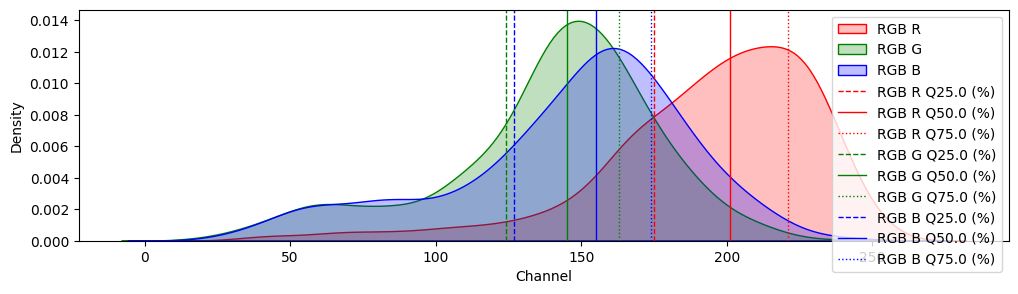

baseline value: 254.0


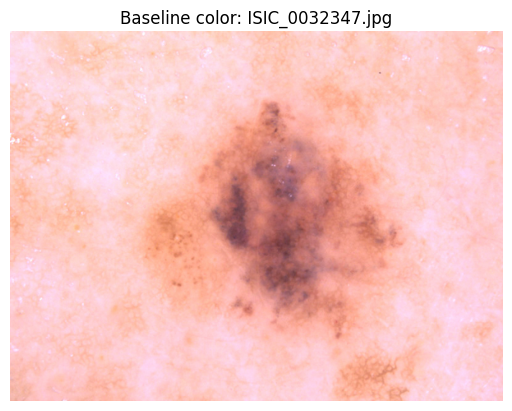

In [8]:
color_analysis = ColorAnalysis(test_df)
color_analysis.plot_color_distribution("RGB R", "RGB G", "RGB B", hist=False)
bl_value, bl_dataframe = color_analysis.select_baseline("RGB R")

In [12]:
color_space = "RGB"
channel = "R"
color_metrics = ColorDistanceMetrics(color_space, channel, bl_dataframe)

test_df["wasserstein {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Wasserstein_Dist)
test_df["kuiper {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Kuiper_Dist)
test_df["anderson {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Anderson_Darling_Dist)
test_df["cvm {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], CVM_Dist)
test_df["kolmogorov {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Kolmogorov_Smirnov_Dist)

In [13]:
test_df.sort_values(by="RGB R", ascending=False)

,lesion_id,image_id,dx,dx_type,age,sex,localization,filepaths,cell_type,labels,...,HSV S,HSV V,LAB L,LAB A,LAB B,wasserstein RGB R,kuiper RGB R,anderson RGB R,cvm RGB R,kolmogorov RGB R
771,HAM_0007585,ISIC_0032347,nv,histo,35.0,female,back,d:/ham/ham/HAM10000_images_part_2/ISIC_0032347...,Melanocytic nevi,0,...,78.0,246.0,218.0,146.0,137.0,0.000000,0.000000,0.000000,0.000000,0.000000
823,HAM_0006364,ISIC_0029027,nv,histo,30.0,female,back,d:/ham/ham/HAM10000_images_part_1/ISIC_0029027...,Melanocytic nevi,0,...,30.0,252.0,233.0,142.0,121.0,1.952953,0.082459,0.018508,1.952843,0.082459
713,HAM_0000397,ISIC_0024538,nv,histo,35.0,male,trunk,d:/ham/ham/HAM10000_images_part_1/ISIC_0024538...,Melanocytic nevi,0,...,110.0,221.0,207.0,153.0,138.0,2.531064,0.254319,0.021582,2.530569,0.254319
317,HAM_0006283,ISIC_0032273,nv,consensus,20.0,male,chest,d:/ham/ham/HAM10000_images_part_2/ISIC_0032273...,Melanocytic nevi,0,...,26.0,228.0,242.0,132.0,131.0,3.631866,0.297018,0.031363,3.631812,0.297018
955,HAM_0007604,ISIC_0027027,bkl,consensus,70.0,female,trunk,d:/ham/ham/HAM10000_images_part_1/ISIC_0027027...,Benign keratosis-like lesions,2,...,53.0,253.0,211.0,150.0,137.0,3.187363,0.360735,0.017073,3.187261,0.360735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,HAM_0007005,ISIC_0032568,nv,histo,40.0,female,acral,d:/ham/ham/HAM10000_images_part_2/ISIC_0032568...,Melanocytic nevi,0,...,28.0,170.0,37.0,129.0,132.0,90.903835,1.000000,0.255254,77.903839,1.000000
454,HAM_0006080,ISIC_0032891,nv,histo,40.0,male,upper extremity,d:/ham/ham/HAM10000_images_part_2/ISIC_0032891...,Melanocytic nevi,0,...,54.0,49.0,35.0,133.0,126.0,85.930292,1.000000,0.235436,69.930287,1.000000
59,HAM_0006071,ISIC_0032343,bkl,histo,70.0,female,face,d:/ham/ham/HAM10000_images_part_2/ISIC_0032343...,Benign keratosis-like lesions,2,...,132.0,43.0,29.0,140.0,119.0,64.024663,0.999895,0.235925,64.024663,0.999895
735,HAM_0001284,ISIC_0024972,mel,histo,75.0,female,ear,d:/ham/ham/HAM10000_images_part_1/ISIC_0024972...,dermatofibroma,1,...,154.0,34.0,23.0,137.0,128.0,73.835082,1.000000,0.249727,73.834907,1.000000


## 1-2. G

baseline value: 240.0


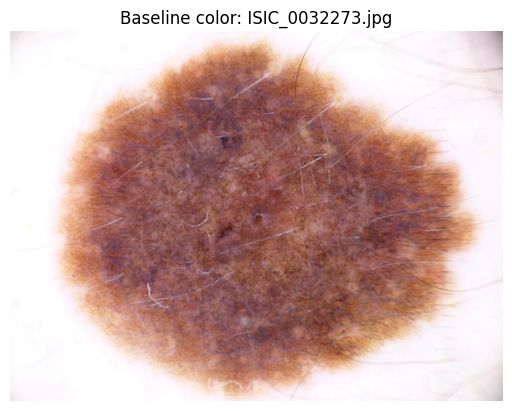

In [37]:
bl_value, bl_dataframe = color_analysis.select_baseline("RGB G")

color_space = "RGB"
channel = "G"
color_metrics = ColorDistanceMetrics(color_space, channel, bl_dataframe)

test_df["wasserstein {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Wasserstein_Dist)
test_df["kuiper {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Kuiper_Dist)
test_df["anderson {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Anderson_Darling_Dist)
test_df["cvm {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], CVM_Dist)
test_df["kolmogorov {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Kolmogorov_Smirnov_Dist)

In [38]:
test_df.sort_values(by="RGB G", ascending=False)

,lesion_id,image_id,dx,dx_type,age,sex,localization,filepaths,cell_type,labels,...,wasserstein RGB R,kuiper RGB R,anderson RGB R,cvm RGB R,kolmogorov RGB R,wasserstein RGB G,kuiper RGB G,anderson RGB G,cvm RGB G,kolmogorov RGB G
317,HAM_0006283,ISIC_0032273,nv,consensus,20.0,male,chest,d:/ham/ham/HAM10000_images_part_2/ISIC_0032273...,Melanocytic nevi,0,...,3.631866,0.297018,0.031363,3.631812,0.297018,0.000000,0.000000,0.000000,0.000000,0.000000
81,HAM_0003676,ISIC_0032530,nv,histo,25.0,female,lower extremity,d:/ham/ham/HAM10000_images_part_2/ISIC_0032530...,Melanocytic nevi,0,...,25.199379,0.968630,0.109691,25.199369,0.968630,14.693716,0.462843,0.064922,14.693716,0.462843
823,HAM_0006364,ISIC_0029027,nv,histo,30.0,female,back,d:/ham/ham/HAM10000_images_part_1/ISIC_0029027...,Melanocytic nevi,0,...,1.952953,0.082459,0.018508,1.952843,0.082459,17.667445,0.580894,0.079602,17.667303,0.580894
921,HAM_0007240,ISIC_0027988,nv,histo,65.0,female,back,d:/ham/ham/HAM10000_images_part_1/ISIC_0027988...,Melanocytic nevi,0,...,13.216705,0.990910,0.049040,13.216705,0.990910,22.253104,0.754608,0.095267,22.253104,0.754608
844,HAM_0002107,ISIC_0028857,nv,histo,85.0,male,back,d:/ham/ham/HAM10000_images_part_1/ISIC_0028857...,Melanocytic nevi,0,...,15.266119,0.785046,0.061766,15.264955,0.785046,25.330416,0.693082,0.105385,25.330355,0.693082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,HAM_0006589,ISIC_0031187,nv,follow_up,40.0,male,trunk,d:/ham/ham/HAM10000_images_part_2/ISIC_0031187...,Melanocytic nevi,0,...,81.361551,1.000000,0.160292,52.361551,1.000000,131.399147,1.000000,0.409009,114.399163,1.000000
931,HAM_0002159,ISIC_0031059,nv,histo,0.0,male,foot,d:/ham/ham/HAM10000_images_part_2/ISIC_0031059...,Melanocytic nevi,0,...,95.696964,1.000000,0.152103,48.696934,1.000000,103.615720,0.999939,0.371940,103.615712,0.999939
738,HAM_0003010,ISIC_0029924,bkl,consensus,55.0,female,face,d:/ham/ham/HAM10000_images_part_2/ISIC_0029924...,Benign keratosis-like lesions,2,...,87.724210,1.000000,0.233647,71.724244,1.000000,123.835649,0.999937,0.449535,123.835649,0.999937
59,HAM_0006071,ISIC_0032343,bkl,histo,70.0,female,face,d:/ham/ham/HAM10000_images_part_2/ISIC_0032343...,Benign keratosis-like lesions,2,...,64.024663,0.999895,0.235925,64.024663,0.999895,93.623480,0.942760,0.370235,93.623480,0.942760


## 1-3. B

baseline value: 246.0


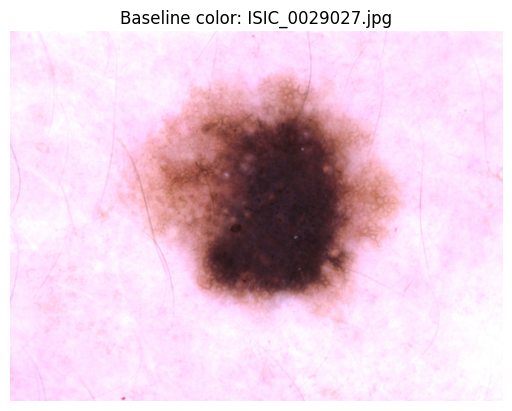

In [39]:
bl_value, bl_dataframe = color_analysis.select_baseline("RGB B")

color_space = "RGB"
channel = "B"
color_metrics = ColorDistanceMetrics(color_space, channel, bl_dataframe)

test_df["wasserstein {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Wasserstein_Dist)
test_df["kuiper {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Kuiper_Dist)
test_df["anderson {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Anderson_Darling_Dist)
test_df["cvm {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], CVM_Dist)
test_df["kolmogorov {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Kolmogorov_Smirnov_Dist)

In [40]:
test_df.sort_values(by="RGB B", ascending=False)

,lesion_id,image_id,dx,dx_type,age,sex,localization,filepaths,cell_type,labels,...,wasserstein RGB G,kuiper RGB G,anderson RGB G,cvm RGB G,kolmogorov RGB G,wasserstein RGB B,kuiper RGB B,anderson RGB B,cvm RGB B,kolmogorov RGB B
823,HAM_0006364,ISIC_0029027,nv,histo,30.0,female,back,d:/ham/ham/HAM10000_images_part_1/ISIC_0029027...,Melanocytic nevi,0,...,17.667445,0.580894,0.079602,17.667303,0.580894,0.000000,0.000000,0.000000,0.000000,0.000000
317,HAM_0006283,ISIC_0032273,nv,consensus,20.0,male,chest,d:/ham/ham/HAM10000_images_part_2/ISIC_0032273...,Melanocytic nevi,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.086523,0.200081,0.031508,6.086523,0.199590
900,HAM_0003230,ISIC_0027640,nv,histo,45.0,male,abdomen,d:/ham/ham/HAM10000_images_part_1/ISIC_0027640...,Melanocytic nevi,0,...,30.703074,0.802426,0.138539,30.703064,0.802426,7.657306,0.450204,0.031567,7.657296,0.450204
669,HAM_0004103,ISIC_0028880,df,histo,55.0,male,lower extremity,d:/ham/ham/HAM10000_images_part_1/ISIC_0028880...,Dermatofibroma,6,...,37.661987,0.815041,0.143096,37.661971,0.815007,16.673652,0.774943,0.073410,16.673652,0.698085
638,HAM_0000144,ISIC_0031127,nv,consensus,40.0,male,back,d:/ham/ham/HAM10000_images_part_2/ISIC_0031127...,Melanocytic nevi,0,...,28.874678,0.832692,0.115613,28.874678,0.828163,20.006708,0.867542,0.070849,20.006708,0.836727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,HAM_0002541,ISIC_0028098,nv,histo,15.0,female,upper extremity,d:/ham/ham/HAM10000_images_part_1/ISIC_0028098...,Melanocytic nevi,0,...,103.740757,0.998985,0.378231,103.740740,0.998985,125.363794,0.970916,0.385656,125.363769,0.970916
931,HAM_0002159,ISIC_0031059,nv,histo,0.0,male,foot,d:/ham/ham/HAM10000_images_part_2/ISIC_0031059...,Melanocytic nevi,0,...,103.615720,0.999939,0.371940,103.615712,0.999939,97.711671,0.965843,0.299363,97.711671,0.965843
259,HAM_0006589,ISIC_0031187,nv,follow_up,40.0,male,trunk,d:/ham/ham/HAM10000_images_part_2/ISIC_0031187...,Melanocytic nevi,0,...,131.399147,1.000000,0.409009,114.399163,1.000000,133.744452,0.998938,0.401659,133.744452,0.998938
738,HAM_0003010,ISIC_0029924,bkl,consensus,55.0,female,face,d:/ham/ham/HAM10000_images_part_2/ISIC_0029924...,Benign keratosis-like lesions,2,...,123.835649,0.999937,0.449535,123.835649,0.999937,113.207518,0.957086,0.353667,113.207518,0.957086


# 2. HSV

## 2-1. H

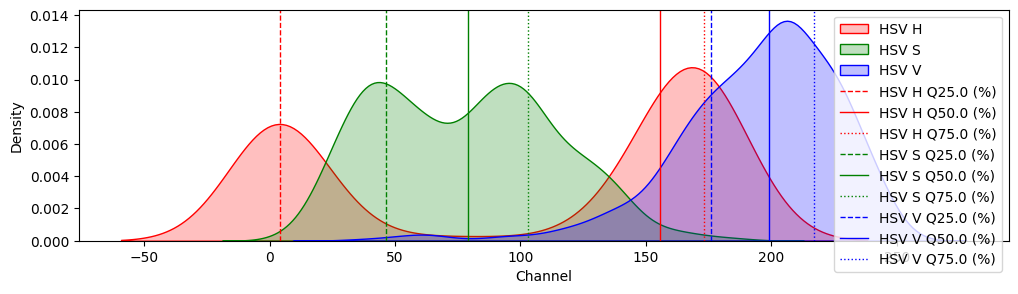

baseline value: 179.0


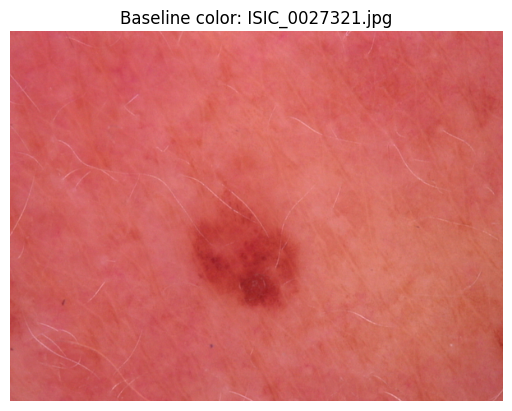

,lesion_id,image_id,dx,dx_type,age,sex,localization,filepaths,cell_type,labels,...,wasserstein LAB B,kuiper LAB B,anderson LAB B,cvm LAB B,kolmogorov LAB B,wasserstein HSV H,kuiper HSV H,anderson HSV H,cvm HSV H,kolmogorov HSV H
351,HAM_0006215,ISIC_0027321,nv,follow_up,55.0,female,upper extremity,d:/ham/ham/HAM10000_images_part_1/ISIC_0027321...,Melanocytic nevi,0,...,8.738665,0.806081,0.034492,8.738665,0.806061,0.000000,0.000000,0.000000,0.000000,0.000000
676,HAM_0002374,ISIC_0024780,nv,follow_up,35.0,male,back,d:/ham/ham/HAM10000_images_part_1/ISIC_0024780...,Melanocytic nevi,0,...,7.020089,0.732690,0.026102,7.020089,0.732435,176.912150,1.000000,0.081582,11.912150,1.000000
851,HAM_0000478,ISIC_0025895,nv,follow_up,40.0,female,upper extremity,d:/ham/ham/HAM10000_images_part_1/ISIC_0025895...,Melanocytic nevi,0,...,1.496238,0.264858,0.007236,1.496238,0.258016,0.538492,0.150193,0.002530,0.538492,0.150193
567,HAM_0001862,ISIC_0031625,nv,follow_up,45.0,male,trunk,d:/ham/ham/HAM10000_images_part_2/ISIC_0031625...,Melanocytic nevi,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,176.018020,1.000000,0.088959,14.018020,1.000000
451,HAM_0000735,ISIC_0029492,nv,follow_up,40.0,female,abdomen,d:/ham/ham/HAM10000_images_part_2/ISIC_0029492...,Melanocytic nevi,0,...,1.154938,0.215563,0.007573,1.154938,0.115706,176.532339,1.000000,0.081933,13.532339,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869,HAM_0004843,ISIC_0031280,nv,follow_up,60.0,male,foot,d:/ham/ham/HAM10000_images_part_2/ISIC_0031280...,Melanocytic nevi,0,...,7.373119,0.759906,0.028977,7.373119,0.759906,1.534262,0.552128,0.007664,1.534262,0.552128
595,HAM_0000292,ISIC_0031445,nv,follow_up,45.0,male,upper extremity,d:/ham/ham/HAM10000_images_part_2/ISIC_0031445...,Melanocytic nevi,0,...,11.854718,0.892308,0.041137,11.854718,0.892308,170.977813,1.000000,0.051931,16.977813,1.000000
226,HAM_0004117,ISIC_0024354,nv,follow_up,40.0,female,abdomen,d:/ham/ham/HAM10000_images_part_1/ISIC_0024354...,Melanocytic nevi,0,...,8.598835,0.808230,0.033313,8.598835,0.808230,174.280556,1.000000,0.049879,16.280556,1.000000
594,HAM_0002351,ISIC_0028788,nv,follow_up,65.0,male,trunk,d:/ham/ham/HAM10000_images_part_1/ISIC_0028788...,Melanocytic nevi,0,...,9.573505,0.807571,0.037035,9.573505,0.807571,173.530089,1.000000,0.050150,16.530089,1.000000


In [47]:
color_analysis = ColorAnalysis(test_df)
color_analysis.plot_color_distribution("HSV H", "HSV S", "HSV V", hist=False)
bl_value, bl_dataframe = color_analysis.select_baseline("HSV H")

color_space = "HSV"
channel = "H"
color_metrics = ColorDistanceMetrics(color_space, channel, bl_dataframe)

test_df["wasserstein {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Wasserstein_Dist)
test_df["kuiper {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Kuiper_Dist)
test_df["anderson {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Anderson_Darling_Dist)
test_df["cvm {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], CVM_Dist)
test_df["kolmogorov {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Kolmogorov_Smirnov_Dist)

test_df.sort_values(by="HSV H", ascending=False)

## 2-2. S

baseline value: 186.0


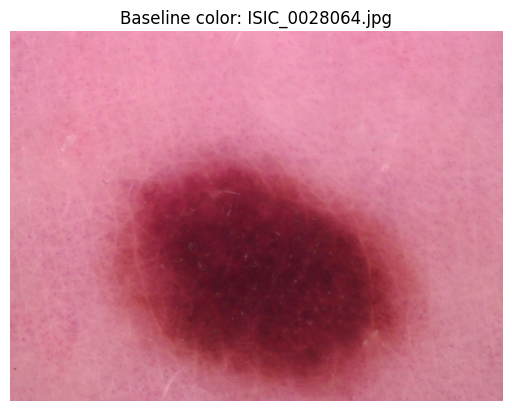

,lesion_id,image_id,dx,dx_type,age,sex,localization,filepaths,cell_type,labels,...,wasserstein RGB B,kuiper RGB B,anderson RGB B,cvm RGB B,kolmogorov RGB B,wasserstein HSV S,kuiper HSV S,anderson HSV S,cvm HSV S,kolmogorov HSV S
438,HAM_0006392,ISIC_0028064,nv,follow_up,20.0,male,lower extremity,d:/ham/ham/HAM10000_images_part_1/ISIC_0028064...,Melanocytic nevi,0,...,86.207384,0.937418,0.288740,86.207384,0.937418,0.000000,0.000000,0.000000,0.000000,0.000000
142,HAM_0004413,ISIC_0026068,vasc,consensus,55.0,female,abdomen,d:/ham/ham/HAM10000_images_part_1/ISIC_0026068...,Vascular lesions,5,...,66.890678,0.937142,0.200891,66.890678,0.928272,24.366501,0.921636,0.096324,24.366501,0.921636
970,HAM_0006228,ISIC_0028594,nv,follow_up,35.0,female,genital,d:/ham/ham/HAM10000_images_part_1/ISIC_0028594...,Melanocytic nevi,0,...,165.066842,0.986543,0.544796,165.066836,0.986543,80.871637,0.894377,0.278351,80.858630,0.894377
330,HAM_0003181,ISIC_0034030,nv,histo,35.0,male,back,d:/ham/ham/HAM10000_images_part_2/ISIC_0034030...,Melanocytic nevi,0,...,81.877526,0.937216,0.252370,81.877526,0.937216,50.660475,0.979994,0.172897,50.660475,0.979944
672,HAM_0006855,ISIC_0030842,nv,histo,50.0,male,back,d:/ham/ham/HAM10000_images_part_2/ISIC_0030842...,Melanocytic nevi,0,...,105.721789,0.935162,0.342610,105.721743,0.935162,44.573221,0.894392,0.170369,44.573207,0.894392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,HAM_0007533,ISIC_0033463,nv,histo,10.0,female,lower extremity,d:/ham/ham/HAM10000_images_part_2/ISIC_0033463...,Melanocytic nevi,0,...,28.687745,0.870710,0.090995,28.687745,0.859817,86.937208,0.997612,0.284912,86.936510,0.997612
216,HAM_0001126,ISIC_0025123,nv,histo,20.0,female,back,d:/ham/ham/HAM10000_images_part_1/ISIC_0025123...,Melanocytic nevi,0,...,56.192112,0.913818,0.180100,56.192112,0.912546,90.478459,0.999658,0.316546,83.485684,0.999658
550,HAM_0002685,ISIC_0030593,nv,histo,30.0,male,chest,d:/ham/ham/HAM10000_images_part_2/ISIC_0030593...,Melanocytic nevi,0,...,52.821377,0.898567,0.178735,52.821372,0.898541,90.303863,0.999315,0.361927,76.317435,0.999155
81,HAM_0003676,ISIC_0032530,nv,histo,25.0,female,lower extremity,d:/ham/ham/HAM10000_images_part_2/ISIC_0032530...,Melanocytic nevi,0,...,21.388474,0.789598,0.076538,21.388474,0.776539,92.235537,0.994499,0.315365,92.235537,0.994499


In [41]:
bl_value, bl_dataframe = color_analysis.select_baseline("HSV S")

color_space = "HSV"
channel = "S"
color_metrics = ColorDistanceMetrics(color_space, channel, bl_dataframe)

test_df["wasserstein {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Wasserstein_Dist)
test_df["kuiper {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Kuiper_Dist)
test_df["anderson {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Anderson_Darling_Dist)
test_df["cvm {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], CVM_Dist)
test_df["kolmogorov {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Kolmogorov_Smirnov_Dist)

test_df.sort_values(by="HSV S", ascending=False)

## 2-3. V

baseline value: 253.0


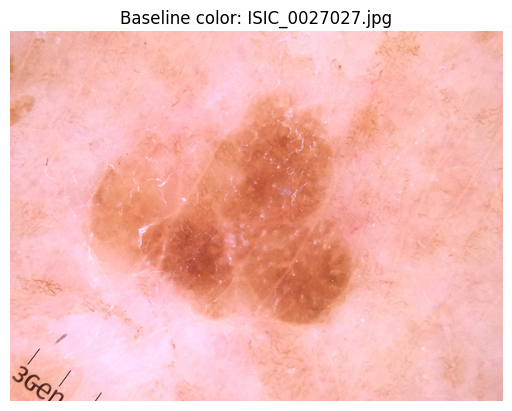

,lesion_id,image_id,dx,dx_type,age,sex,localization,filepaths,cell_type,labels,...,wasserstein HSV S,kuiper HSV S,anderson HSV S,cvm HSV S,kolmogorov HSV S,wasserstein HSV V,kuiper HSV V,anderson HSV V,cvm HSV V,kolmogorov HSV V
955,HAM_0007604,ISIC_0027027,bkl,consensus,70.0,female,trunk,d:/ham/ham/HAM10000_images_part_1/ISIC_0027027...,Benign keratosis-like lesions,2,...,47.327963,0.997380,0.227945,47.327698,0.997380,0.000000,0.000000,0.000000,0.000000,0.000000
823,HAM_0006364,ISIC_0029027,nv,histo,30.0,female,back,d:/ham/ham/HAM10000_images_part_1/ISIC_0029027...,Melanocytic nevi,0,...,69.858445,0.983731,0.243763,69.858445,0.983731,1.763911,0.266220,0.018819,1.747516,0.219439
392,HAM_0004895,ISIC_0027519,nv,histo,40.0,female,foot,d:/ham/ham/HAM10000_images_part_1/ISIC_0027519...,Melanocytic nevi,0,...,38.064184,0.997769,0.139801,38.063895,0.997769,2.228596,0.229246,0.014929,2.217662,0.228945
810,HAM_0005621,ISIC_0028861,nv,follow_up,55.0,male,back,d:/ham/ham/HAM10000_images_part_1/ISIC_0028861...,Melanocytic nevi,0,...,26.226061,0.946297,0.153271,26.225827,0.923016,4.602101,0.260894,0.068046,4.597195,0.260653
505,HAM_0003266,ISIC_0029468,nv,follow_up,30.0,male,abdomen,d:/ham/ham/HAM10000_images_part_2/ISIC_0029468...,Melanocytic nevi,0,...,32.420986,0.984765,0.139957,32.420986,0.984765,5.692280,0.862688,0.032817,5.671533,0.861104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,HAM_0002898,ISIC_0033721,nv,histo,80.0,female,upper extremity,d:/ham/ham/HAM10000_images_part_2/ISIC_0033721...,Melanocytic nevi,0,...,83.226757,0.999781,0.268735,83.226757,0.999781,86.205474,0.999460,0.346830,86.202556,0.999249
286,HAM_0006799,ISIC_0033501,nv,histo,25.0,female,back,d:/ham/ham/HAM10000_images_part_2/ISIC_0033501...,Melanocytic nevi,0,...,52.019424,0.949504,0.180851,52.019424,0.949504,79.080681,0.998175,0.324701,79.078234,0.998027
454,HAM_0006080,ISIC_0032891,nv,histo,40.0,male,upper extremity,d:/ham/ham/HAM10000_images_part_2/ISIC_0032891...,Melanocytic nevi,0,...,75.630282,0.996729,0.259499,75.630200,0.996729,83.876425,0.998533,0.353613,83.875328,0.998413
59,HAM_0006071,ISIC_0032343,bkl,histo,70.0,female,face,d:/ham/ham/HAM10000_images_part_2/ISIC_0032343...,Benign keratosis-like lesions,2,...,39.592518,0.944996,0.158437,39.592518,0.944996,62.686858,0.996455,0.279827,62.684566,0.996311


In [42]:
bl_value, bl_dataframe = color_analysis.select_baseline("HSV V")

color_space = "HSV"
channel = "V"
color_metrics = ColorDistanceMetrics(color_space, channel, bl_dataframe)

test_df["wasserstein {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Wasserstein_Dist)
test_df["kuiper {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Kuiper_Dist)
test_df["anderson {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Anderson_Darling_Dist)
test_df["cvm {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], CVM_Dist)
test_df["kolmogorov {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Kolmogorov_Smirnov_Dist)

test_df.sort_values(by="HSV V", ascending=False)

# 3. Lab

## 3-1. L

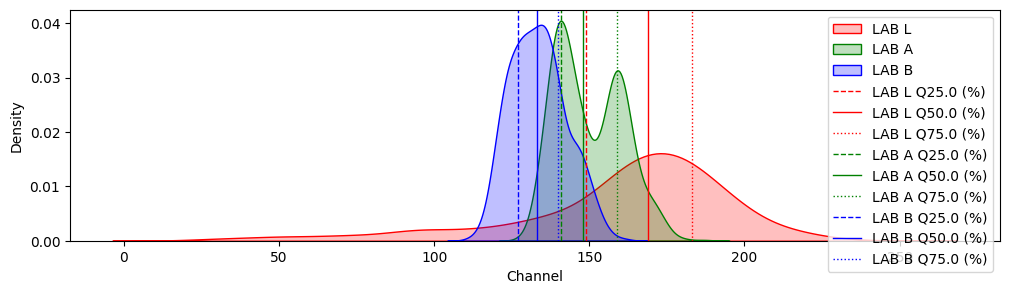

baseline value: 242.0


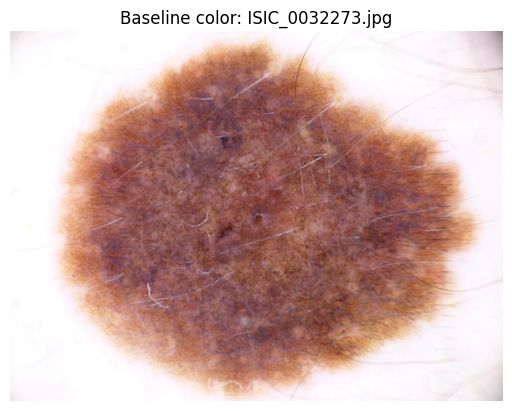

,lesion_id,image_id,dx,dx_type,age,sex,localization,filepaths,cell_type,labels,...,wasserstein HSV V,kuiper HSV V,anderson HSV V,cvm HSV V,kolmogorov HSV V,wasserstein LAB L,kuiper LAB L,anderson LAB L,cvm LAB L,kolmogorov LAB L
317,HAM_0006283,ISIC_0032273,nv,consensus,20.0,male,chest,d:/ham/ham/HAM10000_images_part_2/ISIC_0032273...,Melanocytic nevi,0,...,25.004636,0.290042,0.162305,25.004526,0.245558,0.000000,0.000000,0.000000,0.000000,0.000000
823,HAM_0006364,ISIC_0029027,nv,histo,30.0,female,back,d:/ham/ham/HAM10000_images_part_1/ISIC_0029027...,Melanocytic nevi,0,...,1.763911,0.266220,0.018819,1.747516,0.219439,9.435629,0.540980,0.043533,9.435629,0.537513
81,HAM_0003676,ISIC_0032530,nv,histo,25.0,female,lower extremity,d:/ham/ham/HAM10000_images_part_2/ISIC_0032530...,Melanocytic nevi,0,...,23.429450,0.853242,0.118454,23.425026,0.853001,13.277296,0.509434,0.059417,13.277296,0.509434
921,HAM_0007240,ISIC_0027988,nv,histo,65.0,female,back,d:/ham/ham/HAM10000_images_part_1/ISIC_0027988...,Melanocytic nevi,0,...,9.801431,0.891154,0.052813,9.798532,0.890995,15.524417,0.727057,0.064307,15.524417,0.727057
844,HAM_0002107,ISIC_0028857,nv,histo,85.0,male,back,d:/ham/ham/HAM10000_images_part_1/ISIC_0028857...,Melanocytic nevi,0,...,14.358813,0.675360,0.065396,14.350157,0.675140,18.786737,0.667537,0.076301,18.786685,0.667537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,HAM_0001409,ISIC_0026188,mel,histo,70.0,male,trunk,d:/ham/ham/HAM10000_images_part_1/ISIC_0026188...,dermatofibroma,1,...,56.944983,0.996318,0.315205,56.944983,0.996318,84.647734,0.949198,0.308371,84.647734,0.949198
931,HAM_0002159,ISIC_0031059,nv,histo,0.0,male,foot,d:/ham/ham/HAM10000_images_part_2/ISIC_0031059...,Melanocytic nevi,0,...,96.327887,0.999567,0.396172,94.261252,0.999567,91.378195,0.999996,0.309481,86.378214,0.999996
59,HAM_0006071,ISIC_0032343,bkl,histo,70.0,female,face,d:/ham/ham/HAM10000_images_part_2/ISIC_0032343...,Benign keratosis-like lesions,2,...,62.686858,0.996455,0.279827,62.684566,0.996311,75.311514,0.910519,0.301110,75.311514,0.910519
738,HAM_0003010,ISIC_0029924,bkl,consensus,55.0,female,face,d:/ham/ham/HAM10000_images_part_2/ISIC_0029924...,Benign keratosis-like lesions,2,...,87.783725,0.998772,0.366058,87.783725,0.998772,103.712419,0.999955,0.375980,103.712419,0.999955


In [43]:
color_analysis = ColorAnalysis(test_df)
color_analysis.plot_color_distribution("LAB L", "LAB A", "LAB B", hist=False)
bl_value, bl_dataframe = color_analysis.select_baseline("LAB L")

color_space = "LAB"
channel = "L"
color_metrics = ColorDistanceMetrics(color_space, channel, bl_dataframe)

test_df["wasserstein {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Wasserstein_Dist)
test_df["kuiper {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Kuiper_Dist)
test_df["anderson {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Anderson_Darling_Dist)
test_df["cvm {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], CVM_Dist)
test_df["kolmogorov {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Kolmogorov_Smirnov_Dist)

test_df.sort_values(by="LAB L", ascending=False)

## 3-2. A

baseline value: 187.0


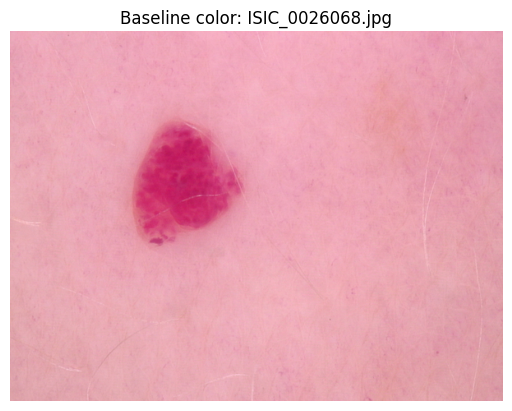

,lesion_id,image_id,dx,dx_type,age,sex,localization,filepaths,cell_type,labels,...,wasserstein LAB L,kuiper LAB L,anderson LAB L,cvm LAB L,kolmogorov LAB L,wasserstein LAB A,kuiper LAB A,anderson LAB A,cvm LAB A,kolmogorov LAB A
142,HAM_0004413,ISIC_0026068,vasc,consensus,55.0,female,abdomen,d:/ham/ham/HAM10000_images_part_1/ISIC_0026068...,Vascular lesions,5,...,51.817041,0.930123,0.189777,51.817041,0.930123,0.000000,0.000000,0.000000,0.000000,0.000000
833,HAM_0006406,ISIC_0026336,vasc,consensus,50.0,male,trunk,d:/ham/ham/HAM10000_images_part_1/ISIC_0026336...,Vascular lesions,5,...,48.661169,0.914813,0.178585,48.661157,0.914813,7.331697,0.867697,0.025313,7.331697,0.867697
969,HAM_0005011,ISIC_0026393,vasc,consensus,80.0,male,trunk,d:/ham/ham/HAM10000_images_part_1/ISIC_0026393...,Vascular lesions,5,...,79.552538,0.998252,0.281789,79.552538,0.998252,0.349568,0.107792,0.001891,0.349568,0.064228
153,HAM_0000845,ISIC_0025244,vasc,consensus,45.0,female,trunk,d:/ham/ham/HAM10000_images_part_1/ISIC_0025244...,Vascular lesions,5,...,65.707995,0.959949,0.240024,65.707995,0.959949,2.494388,0.400369,0.010308,2.494388,0.400369
191,HAM_0007388,ISIC_0031693,nv,follow_up,75.0,male,trunk,d:/ham/ham/HAM10000_images_part_2/ISIC_0031693...,Melanocytic nevi,0,...,92.626005,0.999254,0.330782,92.626005,0.999254,11.303355,0.940519,0.037564,11.303355,0.940519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,HAM_0001126,ISIC_0025123,nv,histo,20.0,female,back,d:/ham/ham/HAM10000_images_part_1/ISIC_0025123...,Melanocytic nevi,0,...,44.710235,0.906922,0.171586,44.710230,0.906922,23.586656,0.999995,0.070265,22.586661,0.999995
748,HAM_0002135,ISIC_0032974,nv,histo,50.0,male,scalp,d:/ham/ham/HAM10000_images_part_2/ISIC_0032974...,Melanocytic nevi,0,...,43.964733,0.819132,0.173218,43.964733,0.819132,24.397894,0.999419,0.080932,24.397894,0.999419
128,HAM_0007005,ISIC_0032568,nv,histo,40.0,female,acral,d:/ham/ham/HAM10000_images_part_2/ISIC_0032568...,Melanocytic nevi,0,...,85.890654,0.959800,0.319171,85.890654,0.959800,22.189568,0.999201,0.069418,22.189568,0.999201
81,HAM_0003676,ISIC_0032530,nv,histo,25.0,female,lower extremity,d:/ham/ham/HAM10000_images_part_2/ISIC_0032530...,Melanocytic nevi,0,...,13.277296,0.509434,0.059417,13.277296,0.509434,26.600517,0.999943,0.085425,26.600517,0.999943


In [44]:
bl_value, bl_dataframe = color_analysis.select_baseline("LAB A")

color_space = "LAB"
channel = "A"
color_metrics = ColorDistanceMetrics(color_space, channel, bl_dataframe)

test_df["wasserstein {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Wasserstein_Dist)
test_df["kuiper {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Kuiper_Dist)
test_df["anderson {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Anderson_Darling_Dist)
test_df["cvm {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], CVM_Dist)
test_df["kolmogorov {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Kolmogorov_Smirnov_Dist)

test_df.sort_values(by="LAB A", ascending=False)

## 3-3. B

baseline value: 162.0


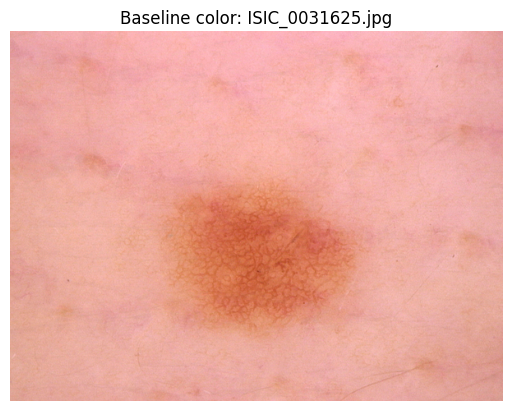

,lesion_id,image_id,dx,dx_type,age,sex,localization,filepaths,cell_type,labels,...,wasserstein LAB A,kuiper LAB A,anderson LAB A,cvm LAB A,kolmogorov LAB A,wasserstein LAB B,kuiper LAB B,anderson LAB B,cvm LAB B,kolmogorov LAB B
567,HAM_0001862,ISIC_0031625,nv,follow_up,45.0,male,trunk,d:/ham/ham/HAM10000_images_part_2/ISIC_0031625...,Melanocytic nevi,0,...,3.755723,0.469469,0.015388,3.755723,0.469469,0.000000,0.000000,0.000000,0.000000,0.000000
9,HAM_0006964,ISIC_0029642,mel,histo,60.0,female,lower extremity,d:/ham/ham/HAM10000_images_part_2/ISIC_0029642...,dermatofibroma,1,...,16.530478,0.982057,0.054959,16.530478,0.982057,6.795299,0.560212,0.026694,6.795299,0.491964
582,HAM_0007050,ISIC_0027160,nv,follow_up,45.0,female,lower extremity,d:/ham/ham/HAM10000_images_part_1/ISIC_0027160...,Melanocytic nevi,0,...,1.090415,0.139797,0.005123,1.090395,0.136608,1.500087,0.179137,0.006881,1.500087,0.179137
90,HAM_0005045,ISIC_0030701,nv,follow_up,40.0,female,trunk,d:/ham/ham/HAM10000_images_part_2/ISIC_0030701...,Melanocytic nevi,0,...,0.801014,0.149743,0.004327,0.801014,0.140613,2.136745,0.195121,0.009843,2.136745,0.194762
353,HAM_0000252,ISIC_0024953,nv,follow_up,45.0,female,trunk,d:/ham/ham/HAM10000_images_part_1/ISIC_0024953...,Melanocytic nevi,0,...,5.846764,0.691147,0.024327,5.846764,0.691120,1.282849,0.233155,0.006665,1.282849,0.140903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,HAM_0006924,ISIC_0032065,nv,histo,40.0,female,chest,d:/ham/ham/HAM10000_images_part_2/ISIC_0032065...,Melanocytic nevi,0,...,14.918131,0.999827,0.051618,14.918131,0.999827,27.617580,1.000000,0.090578,26.617580,1.000000
942,HAM_0002106,ISIC_0025156,nv,histo,45.0,male,foot,d:/ham/ham/HAM10000_images_part_1/ISIC_0025156...,Melanocytic nevi,0,...,17.027725,1.000000,0.051821,17.027725,1.000000,27.244781,0.999964,0.083538,27.244781,0.999964
858,HAM_0004153,ISIC_0026489,mel,histo,80.0,male,foot,d:/ham/ham/HAM10000_images_part_1/ISIC_0026489...,dermatofibroma,1,...,8.633700,0.891728,0.034408,8.633700,0.891728,29.002396,0.999990,0.099650,29.002396,0.999990
57,HAM_0002051,ISIC_0033498,mel,histo,50.0,female,foot,d:/ham/ham/HAM10000_images_part_2/ISIC_0033498...,dermatofibroma,1,...,14.338160,0.981312,0.051770,14.338148,0.981312,28.979705,0.999979,0.099227,28.979705,0.999979


In [45]:
bl_value, bl_dataframe = color_analysis.select_baseline("LAB B")

color_space = "LAB"
channel = "B"
color_metrics = ColorDistanceMetrics(color_space, channel, bl_dataframe)

test_df["wasserstein {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Wasserstein_Dist)
test_df["kuiper {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Kuiper_Dist)
test_df["anderson {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Anderson_Darling_Dist)
test_df["cvm {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], CVM_Dist)
test_df["kolmogorov {} {}".format(color_space, channel)] = color_metrics.compute_distance(test_df["filepaths"], Kolmogorov_Smirnov_Dist)

test_df.sort_values(by="LAB B", ascending=False)

In [49]:
test_df.to_csv(root + "working/df_distance_model2.csv", index=False)